In [15]:
pip install transformers torch sklearn


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [16]:
!pip install datasets


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd


# Splits data into test and train data
def DataSplitter(data_loader):
    test_dataset, train_dataset = random_split(data_loader, [0.3, 0.7])

    print("Train size: " + str(len(train_dataset)))

    print("Test size: " + str(len(test_dataset)))
    print("[+] Training/Testing Set Split")

    train_dataloader = DataLoader(train_dataset, 32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, 32, shuffle=True)
    return train_dataloader, test_dataloader, test_dataset

# Define the function to convert specific labels to group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        # Prepare feature matrix X
        self.X = self.data.drop([self.data.columns[0], self.data.columns[1], self.data.columns[2]], axis=1).values

        # Prepare binary labels
        self.y_binary = self.data[self.data.columns[1]].values

        # Prepare specific labels
        self.y_specific = self.data[self.data.columns[2]].values

        # Prepare group labels
        self.y_group = self.data[self.data.columns[2]].apply(convert_to_group).values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs = torch.tensor(self.X[idx], dtype=torch.float32)
        binary_label = torch.tensor(self.y_binary[idx], dtype=torch.float32)
        group_label = torch.tensor(self.y_group[idx], dtype=torch.long)
        specific_label = torch.tensor(self.y_specific[idx], dtype=torch.long)
        return inputs, binary_label, group_label, specific_label

# Load dataset from disk
csv_file = 'RansomwareData.csv'
dataset = CustomDataset(csv_file)

# Create DataLoader
train_loader, test_loader, test_dataset = DataSplitter(dataset)

# Test DataLoader
for batch in train_loader:
    inputs, binary_labels, group_labels, specific_labels = batch
    print("Inputs:", inputs.shape)
    print("Binary Labels:", binary_labels.shape)
    print("Group Labels:", group_labels.shape)
    print("Specific Labels:", specific_labels.shape)
    break


Train size: 1066
Test size: 457
[+] Training/Testing Set Split
Inputs: torch.Size([32, 30967])
Binary Labels: torch.Size([32])
Group Labels: torch.Size([32])
Specific Labels: torch.Size([32])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaConfig, RobertaModel

class BinaryFeatureEmbedding(nn.Module):
    def __init__(self, num_features, embed_dim):
        super(BinaryFeatureEmbedding, self).__init__()
        self.linear = nn.Linear(num_features, embed_dim)

    def forward(self, x):
        return self.linear(x)

class CustomRoBERTaModel(nn.Module):
    def __init__(self, num_features, embed_dim, num_groups, num_specific):
        super(CustomRoBERTaModel, self).__init__()

        self.embedding = BinaryFeatureEmbedding(num_features, embed_dim)

        config = RobertaConfig(
            vocab_size=num_features,
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            max_position_embeddings=num_features,
            type_vocab_size=2,
            initializer_range=0.02,
            layer_norm_eps=1e-12
        )

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout with probability 0.5

        self.binary_output = nn.Linear(embed_dim, 1)
        self.group_output = nn.Linear(embed_dim, num_groups)
        self.specific_output = nn.Linear(embed_dim, num_specific)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        outputs = self.roberta(inputs_embeds=x)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)  # Apply dropout to the output

        binary_logits = self.binary_output(cls_output)
        binary_probs = torch.sigmoid(binary_logits)

        group_logits = self.group_output(cls_output)
        group_probs = torch.softmax(group_logits, dim=-1)

        specific_logits = self.specific_output(cls_output)
        specific_probs = torch.softmax(specific_logits, dim=-1)

        return binary_probs, group_probs, specific_probs


# Sample usage
num_features = 30967
embed_dim = 768
num_groups = 5
num_specific = 12

model = CustomRoBERTaModel(num_features, embed_dim, num_groups, num_specific)
sample_input = torch.randint(0, 2, (8, num_features)).float()  # batch_size=8, num_features=30964
binary_output, group_output, specific_output = model(sample_input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Binary output shape:", binary_output.shape)
print("Group output shape:", group_output.shape)
print("Specific output shape:", specific_output.shape)


Binary output shape: torch.Size([8, 1])
Group output shape: torch.Size([8, 5])
Specific output shape: torch.Size([8, 12])


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, data_loader, device):
    model.eval()
    binary_true = []
    binary_pred = []
    group_true = []
    group_pred = []
    specific_true = []
    specific_pred = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, binary_labels, group_labels, specific_labels = batch
            inputs = inputs.to(device)
            binary_labels = binary_labels.to(device)
            group_labels = group_labels.to(device)
            specific_labels = specific_labels.to(device)
            binary_probs, group_probs, specific_probs = model(inputs)
            binary_preds = (binary_probs > 0.5).float()
            group_preds = torch.argmax(group_probs, dim=1)
            specific_preds = torch.argmax(specific_probs, dim=1)
            binary_true.extend(binary_labels.cpu().numpy())
            binary_pred.extend(binary_preds.cpu().numpy())
            group_true.extend(group_labels.cpu().numpy())
            group_pred.extend(group_preds.cpu().numpy())
            specific_true.extend(specific_labels.cpu().numpy())
            specific_pred.extend(specific_preds.cpu().numpy())

    # Binary classification metrics
    binary_accuracy = accuracy_score(binary_true, binary_pred)
    binary_precision = precision_score(binary_true, binary_pred)
    binary_recall = recall_score(binary_true, binary_pred)
    binary_f1 = f1_score(binary_true, binary_pred)

    # Group classification metrics
    group_accuracy = accuracy_score(group_true, group_pred)
    group_precision = precision_score(group_true, group_pred, average='weighted')
    group_recall = recall_score(group_true, group_pred, average='weighted')
    group_f1 = f1_score(group_true, group_pred, average='weighted')

    # Specific classification metrics
    specific_accuracy = accuracy_score(specific_true, specific_pred)
    specific_precision = precision_score(specific_true, specific_pred, average='weighted')
    specific_recall = recall_score(specific_true, specific_pred, average='weighted')
    specific_f1 = f1_score(specific_true, specific_pred, average='weighted')

    metrics = {
        "binary_accuracy": binary_accuracy,
        "binary_precision": binary_precision,
        "binary_recall": binary_recall,
        "binary_f1": binary_f1,
        "group_accuracy": group_accuracy,
        "group_precision": group_precision,
        "group_recall": group_recall,
        "group_f1": group_f1,
        "specific_accuracy": specific_accuracy,
        "specific_precision": specific_precision,
        "specific_recall": specific_recall,
        "specific_f1": specific_f1,
    }

    return metrics


In [20]:
#PLOT

binary_acc = []
val_binary_acc = []
group_acc = []
val_group_acc = []
specific_acc = []
val_specific_acc = []

In [21]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import os


# Example usage
binary_loss_fn = nn.BCELoss()
group_loss_fn = nn.CrossEntropyLoss()
specific_loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

writer = SummaryWriter(log_dir=os.path.join("runs", "exp1"))

best_val_loss = float('inf')
early_stopping_patience = 5
patience_counter = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        inputs, binary_labels, group_labels, specific_labels = batch
        optimizer.zero_grad()

        binary_probs, group_probs, specific_probs = model(inputs)

        binary_loss = binary_loss_fn(binary_probs, binary_labels.unsqueeze(1))
        group_loss = group_loss_fn(group_probs, group_labels)
        specific_loss = specific_loss_fn(specific_probs, specific_labels)

        loss = binary_loss + group_loss + specific_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log epoch loss
    metrics = evaluate(model, train_loader, device)

    val_metrics = evaluate(model, test_loader, device)

    val_loss = sum(val_metrics.values())  # Sum of all validation metrics as a proxy for validation loss


    binary_acc.append(metrics['binary_accuracy'])
    val_binary_acc.append(val_metrics['binary_accuracy'])
    group_acc.append(metrics['group_accuracy'])
    val_group_acc.append(val_metrics['group_accuracy'])
    specific_acc.append(metrics['specific_accuracy'])
    val_specific_acc.append(val_metrics['specific_accuracy'])
    # Logging
    writer.add_scalar("Loss/train", epoch_loss/len(train_loader), epoch)
    writer.add_scalar("Loss/validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Binary", val_metrics['binary_accuracy'], epoch)
    writer.add_scalar("Accuracy/Group", val_metrics['group_accuracy'], epoch)
    writer.add_scalar("Accuracy/Specific", val_metrics['specific_accuracy'], epoch)
    print("*" * 32)
    print(metrics)
    print(val_metrics)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss/len(train_loader)}, Val Loss: {val_loss}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9521575984990619, 'binary_precision': 0.9232558139534883, 'binary_recall': 0.9566265060240964, 'binary_f1': 0.9396449704142011, 'group_accuracy': 0.7270168855534709, 'group_precision': 0.633214143016878, 'group_recall': 0.7270168855534709, 'group_f1': 0.6610712084708371, 'specific_accuracy': 0.6716697936210131, 'specific_precision': 0.5389214679638793, 'specific_recall': 0.6716697936210131, 'specific_f1': 0.5881357707723797}
{'binary_accuracy': 0.9168490153172867, 'binary_precision': 0.8516483516483516, 'binary_recall': 0.9337349397590361, 'binary_f1': 0.8908045977011494, 'group_accuracy': 0.7133479212253829, 'group_precision': 0.6442729816482285, 'group_recall': 0.7133479212253829, 'group_f1': 0.6581947616602694, 'specific_accuracy': 0.6761487964989059, 'specific_precision': 0.5536439609184344, 'specific_recall': 0.6761487964989059, 'specific_f1': 0.6003278990149887}
Epoch 1/20, Train Loss: 3.8268068748361923, Val Loss: 8.82846994

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9390243902439024, 'binary_precision': 1.0, 'binary_recall': 0.8433734939759037, 'binary_f1': 0.9150326797385622, 'group_accuracy': 0.7195121951219512, 'group_precision': 0.5884661144922894, 'group_recall': 0.7195121951219512, 'group_f1': 0.6407391832181729, 'specific_accuracy': 0.6707317073170732, 'specific_precision': 0.52789058392858, 'specific_recall': 0.6707317073170732, 'specific_f1': 0.5827776903738471}
{'binary_accuracy': 0.9343544857768052, 'binary_precision': 0.9927536231884058, 'binary_recall': 0.8253012048192772, 'binary_f1': 0.9013157894736843, 'group_accuracy': 0.7352297592997812, 'group_precision': 0.600791943974976, 'group_recall': 0.7352297592997812, 'group_f1': 0.6532028371920497, 'specific_accuracy': 0.6805251641137856, 'specific_precision': 0.5469710834594651, 'specific_recall': 0.6805251641137856, 'specific_f1': 0.5982581427630747}
Epoch 2/20, Train Loss: 3.2684968990438126, Val Loss: 8.88445895747487


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9878048780487805, 'binary_precision': 0.9975247524752475, 'binary_recall': 0.9710843373493976, 'binary_f1': 0.9841269841269842, 'group_accuracy': 0.7420262664165104, 'group_precision': 0.6410578827820688, 'group_recall': 0.7420262664165104, 'group_f1': 0.6730205371704654, 'specific_accuracy': 0.6791744840525328, 'specific_precision': 0.5886633933154529, 'specific_recall': 0.6791744840525328, 'specific_f1': 0.6158570535565279}
{'binary_accuracy': 0.9649890590809628, 'binary_precision': 0.9807692307692307, 'binary_recall': 0.9216867469879518, 'binary_f1': 0.9503105590062112, 'group_accuracy': 0.7352297592997812, 'group_precision': 0.6372021455151672, 'group_recall': 0.7352297592997812, 'group_f1': 0.6689397977333766, 'specific_accuracy': 0.6827133479212254, 'specific_precision': 0.598498017865331, 'specific_recall': 0.6827133479212254, 'specific_f1': 0.6251641778237145}
Epoch 3/20, Train Loss: 3.2241073355955234, Val Loss: 9.18344594

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9906191369606003, 'binary_precision': 0.9975429975429976, 'binary_recall': 0.9783132530120482, 'binary_f1': 0.9878345498783455, 'group_accuracy': 0.7485928705440901, 'group_precision': 0.7279582565349678, 'group_recall': 0.7485928705440901, 'group_f1': 0.698902916160773, 'specific_accuracy': 0.6848030018761726, 'specific_precision': 0.6162770036870623, 'specific_recall': 0.6848030018761726, 'specific_f1': 0.6307424419225431}
{'binary_accuracy': 0.9781181619256017, 'binary_precision': 0.9698795180722891, 'binary_recall': 0.9698795180722891, 'binary_f1': 0.9698795180722891, 'group_accuracy': 0.7352297592997812, 'group_precision': 0.6909887051811513, 'group_recall': 0.7352297592997812, 'group_f1': 0.6859267424399846, 'specific_accuracy': 0.6805251641137856, 'specific_precision': 0.6579902178124671, 'specific_recall': 0.6805251641137856, 'specific_f1': 0.6427539749055192}
Epoch 4/20, Train Loss: 3.173440743895138, Val Loss: 9.396926203

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

********************************
{'binary_accuracy': 0.9934333958724203, 'binary_precision': 0.9857142857142858, 'binary_recall': 0.9975903614457832, 'binary_f1': 0.9916167664670659, 'group_accuracy': 0.7495309568480301, 'group_precision': 0.7407269031942296, 'group_recall': 0.7495309568480301, 'group_f1': 0.7011953334151622, 'specific_accuracy': 0.6857410881801126, 'specific_precision': 0.6278945682514986, 'specific_recall': 0.6857410881801126, 'specific_f1': 0.6349677942198974}
{'binary_accuracy': 0.9343544857768052, 'binary_precision': 0.8655913978494624, 'binary_recall': 0.9698795180722891, 'binary_f1': 0.9147727272727273, 'group_accuracy': 0.7133479212253829, 'group_precision': 0.6944843085433894, 'group_recall': 0.7133479212253829, 'group_f1': 0.6754008499097339, 'specific_accuracy': 0.6586433260393874, 'specific_precision': 0.6503816869165094, 'specific_recall': 0.6586433260393874, 'specific_f1': 0.6344704811306808}
Epoch 5/20, Train Loss: 3.125901264302871, Val Loss: 9.08331795

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************************
{'binary_accuracy': 0.9765478424015009, 'binary_precision': 0.9949238578680203, 'binary_recall': 0.944578313253012, 'binary_f1': 0.9690976514215079, 'group_accuracy': 0.7598499061913696, 'group_precision': 0.7080025016392225, 'group_recall': 0.7598499061913696, 'group_f1': 0.7208556886292267, 'specific_accuracy': 0.6810506566604128, 'specific_precision': 0.6097648687662494, 'specific_recall': 0.6810506566604128, 'specific_f1': 0.6304694759233878}
{'binary_accuracy': 0.962800875273523, 'binary_precision': 0.9408284023668639, 'binary_recall': 0.9578313253012049, 'binary_f1': 0.9492537313432836, 'group_accuracy': 0.737417943107221, 'group_precision': 0.7028044393607851, 'group_recall': 0.737417943107221, 'group_f1': 0.7093701291584537, 'specific_accuracy': 0.6673960612691466, 'specific_precision': 0.6281185532264378, 'specific_recall': 0.6673960612691466, 'specific_f1': 0.6329878812838869}
Epoch 6/20, Train Loss: 3.163149314768174, Val Loss: 9.293623346067

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
print(str(len(binary_acc)) + " Epochs\nTraining Metrics:")
print(metrics)
print("Testing Metrics:")
print(val_metrics)

6 Epochs
Training Metrics:
{'binary_accuracy': 0.9765478424015009, 'binary_precision': 0.9949238578680203, 'binary_recall': 0.944578313253012, 'binary_f1': 0.9690976514215079, 'group_accuracy': 0.7598499061913696, 'group_precision': 0.7080025016392225, 'group_recall': 0.7598499061913696, 'group_f1': 0.7208556886292267, 'specific_accuracy': 0.6810506566604128, 'specific_precision': 0.6097648687662494, 'specific_recall': 0.6810506566604128, 'specific_f1': 0.6304694759233878}
Testing Metrics:
{'binary_accuracy': 0.962800875273523, 'binary_precision': 0.9408284023668639, 'binary_recall': 0.9578313253012049, 'binary_f1': 0.9492537313432836, 'group_accuracy': 0.737417943107221, 'group_precision': 0.7028044393607851, 'group_recall': 0.737417943107221, 'group_f1': 0.7093701291584537, 'specific_accuracy': 0.6673960612691466, 'specific_precision': 0.6281185532264378, 'specific_recall': 0.6673960612691466, 'specific_f1': 0.6329878812838869}


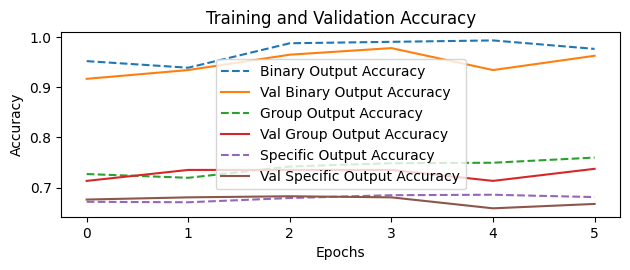

In [23]:
import matplotlib.pyplot as plt
# Plot loss
# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(binary_acc, linestyle='--', label='Binary Output Accuracy')
plt.plot(val_binary_acc, label='Val Binary Output Accuracy')
plt.plot(group_acc, linestyle='--', label='Group Output Accuracy')
plt.plot(val_group_acc, label='Val Group Output Accuracy')
plt.plot(specific_acc, linestyle='--', label='Specific Output Accuracy')
plt.plot(val_specific_acc, label='Val Specific Output Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


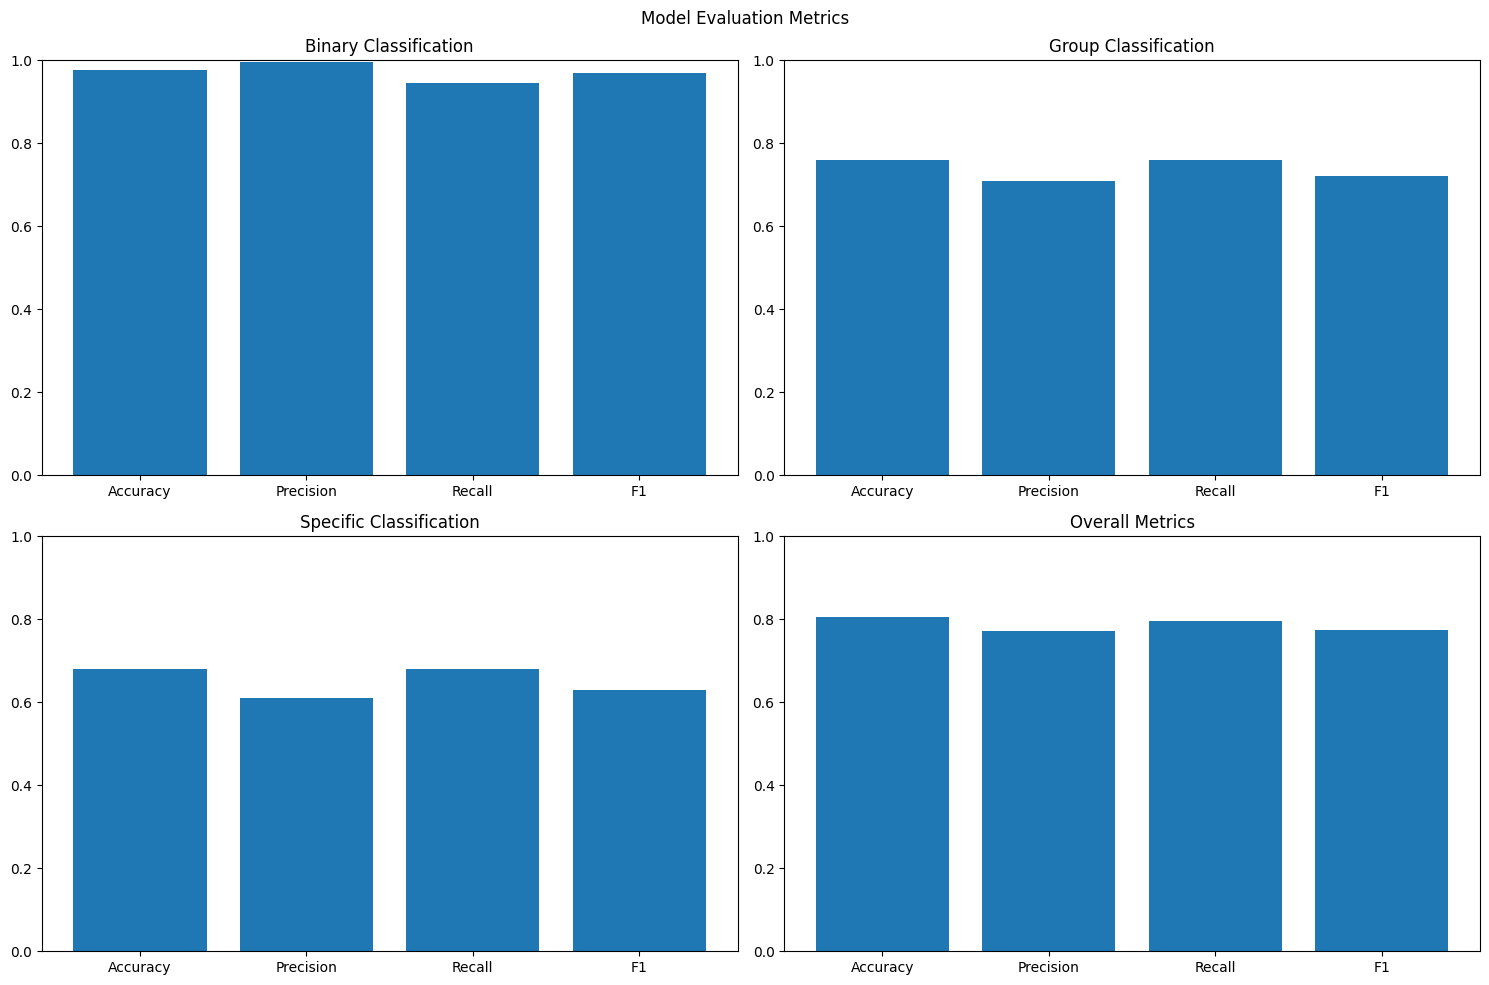

In [24]:
import matplotlib.pyplot as plt

# Plotting the metrics
def plot_metrics(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Evaluation Metrics')

    # Binary Classification Metrics
    axes[0, 0].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['binary_accuracy'], metrics['binary_precision'], metrics['binary_recall'], metrics['binary_f1']])
    axes[0, 0].set_title('Binary Classification')
    axes[0, 0].set_ylim(0, 1)

    # Group Classification Metrics
    axes[0, 1].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['group_accuracy'], metrics['group_precision'], metrics['group_recall'], metrics['group_f1']])
    axes[0, 1].set_title('Group Classification')
    axes[0, 1].set_ylim(0, 1)

    # Specific Classification Metrics
    axes[1, 0].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [metrics['specific_accuracy'], metrics['specific_precision'], metrics['specific_recall'], metrics['specific_f1']])
    axes[1, 0].set_title('Specific Classification')
    axes[1, 0].set_ylim(0, 1)

    # Overall Metrics
    overall_accuracy = (metrics['binary_accuracy'] + metrics['group_accuracy'] + metrics['specific_accuracy']) / 3
    overall_precision = (metrics['binary_precision'] + metrics['group_precision'] + metrics['specific_precision']) / 3
    overall_recall = (metrics['binary_recall'] + metrics['group_recall'] + metrics['specific_recall']) / 3
    overall_f1 = (metrics['binary_f1'] + metrics['group_f1'] + metrics['specific_f1']) / 3

    axes[1, 1].bar(['Accuracy', 'Precision', 'Recall', 'F1'],
                   [overall_accuracy, overall_precision, overall_recall, overall_f1])
    axes[1, 1].set_title('Overall Metrics')
    axes[1, 1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)